In [1]:
import dgl
from Datasets.NodeClassification.Citeseer import Citeseer
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
import torch
import numpy as np

/home/robin/uu/thesis/convolution-matching/.venvconv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Citeseer() 
original_graph = dataset.load_graph()


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:

coarsener = HeteroCoarsener(None,original_graph, 0.1, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10)
coarsener.init_step()
isNewMerges = True
for i in range(1000):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()
    

/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_out = torch.tensor(self.node_degrees[etype]['out'], device=self.device) + 1.0
/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg_in  = torch.tensor(self.node_degrees[etype]['in'], device=self.device)  + 1.0


_create_h_spatial_rgcn 0.007470607757568359
_init_costs 0.1588423252105713
_get_union 0.06200456619262695
_costs_of_merges 1.1282765865325928
_init_merge_graph 0.002956867218017578
_find_lowest_cost_edges 0.0034275054931640625
--------- step:  0 ---------
_merge_nodes 0.03285479545593262


/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:650: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node1s = torch.tensor(node1s, dtype=torch.long)
/home/robin/uu/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:651: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node2s = torch.tensor(node2s, dtype=torch.long)


_update_merge_graph 0.9345998764038086
_find_lowest_cost_edges 0.003381967544555664
--------- step:  1 ---------
_merge_nodes 0.029967784881591797
_update_merge_graph 1.2389273643493652
_find_lowest_cost_edges 0.002242565155029297
--------- step:  2 ---------
_merge_nodes 0.029555320739746094
_update_merge_graph 0.9994223117828369
_find_lowest_cost_edges 0.003495454788208008
--------- step:  3 ---------
_merge_nodes 0.047731637954711914
_update_merge_graph 0.9517533779144287
_find_lowest_cost_edges 0.0017249584197998047
--------- step:  4 ---------
_merge_nodes 0.028369426727294922
_update_merge_graph 0.9012300968170166
_find_lowest_cost_edges 0.003152608871459961
--------- step:  5 ---------
_merge_nodes 0.026093006134033203
_update_merge_graph 0.8931088447570801
_find_lowest_cost_edges 0.0016329288482666016
--------- step:  6 ---------
_merge_nodes 0.02819657325744629
_update_merge_graph 0.882493257522583
_find_lowest_cost_edges 0.0013241767883300781
--------- step:  7 ---------
_mer

In [4]:
coarsend_graph = coarsener.get_coarsend_graph()
dgl.save_graphs("citeer_graph.bin", [coarsend_graph])
mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")

coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=coarsend_graph.device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.09828674481514878


In [10]:
len(coarsener.evaluations_distances)

500

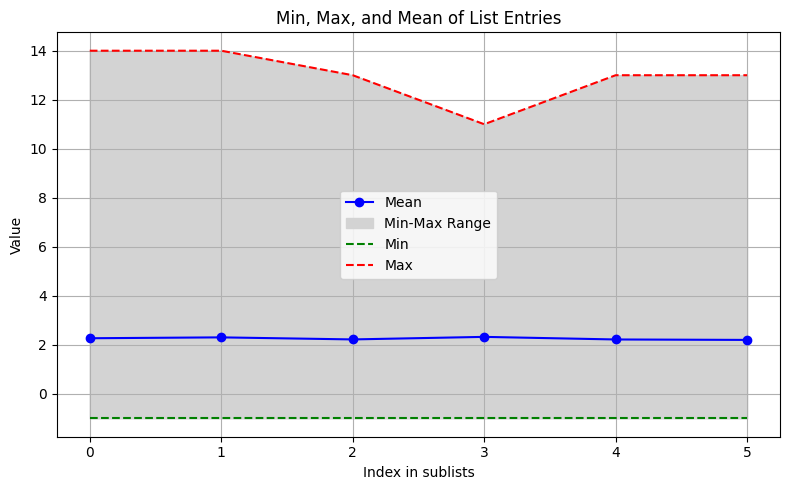

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = coarsener.evaluations_distances

# Convert to NumPy array for easier manipulation
arr = np.array(data)

# Compute statistics across rows (axis=0)
mins = arr.min(axis=0)
maxs = arr.max(axis=0)
means = arr.mean(axis=0)

# X-axis positions (index of each element in sublists)
x = np.arange(arr.shape[1])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, means, label='Mean', color='blue', marker='o')
plt.fill_between(x, mins, maxs, color='lightgray', label='Min-Max Range')
plt.plot(x, mins, label='Min', linestyle='--', color='green')
plt.plot(x, maxs, label='Max', linestyle='--', color='red')

plt.xlabel('Index in sublists')
plt.ylabel('Value')
plt.title('Min, Max, and Mean of List Entries')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


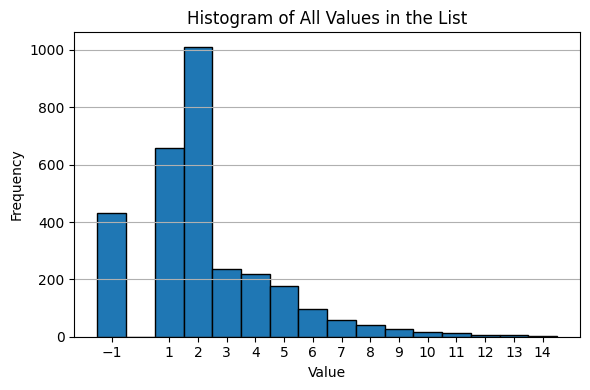

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = coarsener.evaluations_distances

# Flatten the list of lists into a 1D list
flattened = [item for sublist in data for item in sublist]

# Optional: Convert to NumPy array for better performance
flattened_array = np.array(flattened)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(flattened_array, bins=np.arange(flattened_array.min(), flattened_array.max() + 2) - 0.5, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of All Values in the List')
plt.grid(axis='y')
plt.xticks(np.unique(flattened_array))
plt.tight_layout()
plt.show()
